In [1]:
import numpy as np
import os, shutil
import PIL as pil
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf

In [2]:
batch_size = 128
original_dim = 7500
latent_dim = 100
intermediate_dim = 512
epochs = 50
epsilon_std = 1.0

In [26]:
class NameSpacer:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


class Architecture:
    def __init__(self, batch_size=None, original_dim=None, latent_dim=2,
                 intermediate_dim=256, name="architecture", nrows=50, ncols=50, nchannels=3):
        self.name = name
        self.batch_size = batch_size
        self.original_dim = original_dim
        self.nrows = nrows
        self.ncols = ncols
        self.nchannels = nchannels
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        self.define_computation_graph()

        # Aliases
        self.ph = self.placeholders
        self.op = self.optimizers
        self.summ = self.summaries

    def define_computation_graph(self):
        # Reset graph
        tf.reset_default_graph()
        self.placeholders = NameSpacer(**self.define_placeholders())
        self.core_model = NameSpacer(**self.define_core_model())
        self.losses = NameSpacer(**self.define_losses())
        self.optimizers = NameSpacer(**self.define_optimizers())
        self.summaries = NameSpacer(**self.define_summaries())

    def define_placeholders(self):
        with tf.variable_scope("Placeholders"):
            loss_dev = tf.placeholder(dtype=tf.float32, shape=(None), 
                                      name="loss_dev")
            x = tf.placeholder(dtype=tf.float32, shape=(self.batch_size, self.nrows, self.ncols, self.nchannels),
                                                       name="input")
            z = tf.placeholder(dtype=tf.float32, shape=(None, self.latent_dim),
                                                       name="latent_vector")
            

            return {"loss_dev": loss_dev,
                   "x": x,
                   "z": z}
    
    def define_core_model(self):
        with tf.variable_scope("Core_Model"):
                        
            encode_x, encoded_means, encoded_stds = self.encode(self.placeholders.x)
            vae = self.decode(encode_x)
            
            decode_z = self.decode(self.placeholders.z, reuse=True)
            
            return {"output": vae,
                   "output_z": decode_z,
                    "z_means":encoded_means,
                    "z_log_stds": encoded_stds,
                    "encoded_x":encode_x
                   }

    def define_losses(self):
        with tf.variable_scope("Losses"):
            mse = tf.reduce_sum(tf.square(self.core_model.output-self.placeholders.x), axis=1)
            
            recon_loss = tf.reduce_mean(mse)
            kl_loss = tf.reduce_mean(- 0.5 * tf.reduce_sum(1 + self.core_model.z_log_stds -
                                                           tf.square(self.core_model.z_means) - 
                                                           tf.exp(self.core_model.z_log_stds),1))
            kl_loss = tf.reduce_mean(kl_loss)

            total_loss = tf.reduce_mean(recon_loss + 0.001*kl_loss)
            
            #total_loss = tf.reduce_mean(mse + kl_loss)/1
            return {"loss": recon_loss,
                   "kl_loss": kl_loss,
                   "total_loss": total_loss}

    def define_optimizers(self):
        with tf.variable_scope("Optimization"):
            op = self.optimizer.minimize(self.losses.total_loss)
            return {"op": op}

    def define_summaries(self):
        with tf.variable_scope("Summaries"):
            train_final_scalar_probes = {"loss": tf.squeeze(self.losses.loss),
                                        "kl_loss":tf.squeeze(self.losses.kl_loss),
                                        "total_loss":tf.squeeze(self.losses.total_loss)}
            final_performance_scalar = [tf.summary.scalar(k, tf.reduce_mean(v), family=self.name)
                                        for k, v in train_final_scalar_probes.items()]
            dev_scalar_probes = {"loss_dev": self.placeholders.loss_dev}
            dev_performance_scalar = [tf.summary.scalar(k, v, family=self.name) for k, v in dev_scalar_probes.items()]
            dev_performance_scalar = tf.summary.merge(dev_performance_scalar)
            
            return {"scalar_train_performance": tf.summary.merge(final_performance_scalar),
                    "scalar_dev_performance": dev_performance_scalar}
    def encode(self, x):
        with tf.variable_scope("Encoder"):
            dense_enc_1 = tf.layers.conv2d(self.placeholders.x, filters=32, kernel_size=(3,3))
            #dense_enc_2 = tf.layers.conv2d(dense_enc_1, filters=64, kernel_size=(3,3))
            flat = tf.contrib.layers.flatten(dense_enc_1)
            z_mean = tf.layers.dense(flat, self.latent_dim, activation=None,
                                     name="dense_mean")
            z_log_sd = tf.layers.dense(flat, self.latent_dim, activation=None,
                                       name="dense_sd")
            samples = tf.random_normal(tf.shape(z_mean),0,1,dtype=tf.float32)  
            sampled_z = z_mean + (tf.exp(z_log_sd) * samples)
            
            return sampled_z, z_mean, z_log_sd
        
    def decode(self, dec_input, reuse=False):
        with tf.variable_scope("Decoder", reuse=reuse):
            dense_dec_1 = tf.layers.dense(dec_input, self.nrows*self.ncols*self.nchannels, activation=tf.nn.relu)
            dense_dec_2 = tf.layers.dense(dense_dec_1, self.nrows*self.ncols*self.nchannels, activation=tf.nn.sigmoid)
            decoder_mean = tf.reshape(dense_dec_2, (tf.shape(dec_input)[0], self.nrows, self.ncols, self.nchannels))
            return decoder_mean
            


In [27]:
net = Architecture(batch_size=batch_size, intermediate_dim=intermediate_dim, latent_dim=latent_dim, original_dim=original_dim)

In [48]:
sess = tf.Session()

In [49]:
sess.run(tf.global_variables_initializer())

In [50]:
def get_summary_writer(session, logs_path, project_id, version_id, remove_if_exists=True):
    """
    For Tensorboard reporting
    :param session: opened tensorflow session (tf.Session)
    :param logs_path: path where tensorboard is looking for logs (str)
    :param project_id: name of the project for reporting purposes (str)
    :param version_id: name of the version for reporting purposes (str)
    :param remove_if_exists: if True removes the log in case it exists (bool)
    :return summary_writer: the tensorboard writer
    """
    path = os.path.join(logs_path, "{}_{}".format(project_id, version_id))
    if os.path.exists(path) and remove_if_exists:
        shutil.rmtree(path)
    summary_writer = tf.summary.FileWriter(path, graph_def=session.graph_def)
    return summary_writer

In [51]:
sw = get_summary_writer(sess, "/home/user/tensorflow_logs/", "VAE_tf", "LFW_CONV_1")


In [52]:
path_lfw = "/home/user/lfw/hola"
images_path = os.listdir(path_lfw)

data_ = [np.array(pil.Image.open(os.path.join(path_lfw, x)).resize((50, 50))) for x in images_path]

In [53]:
np.random.seed(1616)

In [54]:
np.random.shuffle(data_)

In [55]:
x_train = data_[:13000]
x_test = data_[13000:]

In [56]:
x_train = [(i.astype('float32') / 255) for i in x_train]
x_test = [(i.astype('float32') / 255) for i in x_test]

In [57]:
def batching(list_of_iterables, n=1, infinite=False, return_incomplete_batches=False):
    list_of_iterables = [list_of_iterables] if type(list_of_iterables) is not list else list_of_iterables
    assert(len({len(it) for it in list_of_iterables}) == 1)
    n_elements = len(list_of_iterables[0])
    while 1:
        for ndx in range(0, n_elements, n):
            if not return_incomplete_batches:
                if (ndx+n) > n_elements:
                    break
            yield [iterable[ndx:min(ndx + n, n_elements)] for iterable in list_of_iterables]

        if not infinite:
            break

In [58]:
c=0

In [59]:

for e in range(20):
    losses_dev = []
    batcher = batching([x_test], net.batch_size)
    for (b,) in batcher:
        s = sess.run([net.losses.loss],
                        feed_dict={net.placeholders.x: b})
        losses_dev.append(s)
    losses_dev = np.mean(losses_dev)
    batcher = batching([x_train], net.batch_size)
    for (b,) in batcher:
        _, recon, kl, tot, summ_train = sess.run([net.op.op, net.losses.loss, 
                                                  net.losses.kl_loss, net.losses.total_loss, 
                                     net.summ.scalar_train_performance],
                        feed_dict={net.placeholders.x: b})
        sw.add_summary(summ_train, c)
        c+=1
    if e % 5 == 0:
        print("Epoch: "+str(e)+ " recon_loss: "+str(recon)+" kl_loss: "+str(kl)+" tot_loss: "+str(tot))
        
    s = sess.run(net.summ.scalar_dev_performance, feed_dict={net.ph.loss_dev: losses_dev})
    sw.add_summary(s, c)
    print("Epoch: "+str(e)+ " loss_dev: "+str(losses_dev))
    
        

Epoch: 0 recon_loss: 1.5626 kl_loss: 121.537 tot_loss: 1.68413
Epoch: 0 loss_dev: 4.6371
Epoch: 1 loss_dev: 1.45532
Epoch: 2 loss_dev: 1.02989
Epoch: 3 loss_dev: 0.850721
Epoch: 4 loss_dev: 0.758517
Epoch: 5 recon_loss: 0.653783 kl_loss: 117.172 tot_loss: 0.770954
Epoch: 5 loss_dev: 0.719241
Epoch: 6 loss_dev: 0.704909
Epoch: 7 loss_dev: 0.728673
Epoch: 8 loss_dev: 0.707543
Epoch: 9 loss_dev: 0.726595
Epoch: 10 recon_loss: 0.616773 kl_loss: 124.332 tot_loss: 0.741105
Epoch: 10 loss_dev: 0.712111
Epoch: 11 loss_dev: 0.709952
Epoch: 12 loss_dev: 0.767759
Epoch: 13 loss_dev: 0.725931
Epoch: 14 loss_dev: 0.743428
Epoch: 15 recon_loss: 0.532099 kl_loss: 121.222 tot_loss: 0.653321
Epoch: 15 loss_dev: 0.739565
Epoch: 16 loss_dev: 0.746135
Epoch: 17 loss_dev: 0.761738
Epoch: 18 loss_dev: 0.762906
Epoch: 19 loss_dev: 0.779231


In [60]:
batcher = batching([x_test], net.batch_size)
decoded_imgs = []
encoded_imgs = []
for (b,) in batcher:
    b_decoded_imgs = sess.run(net.core_model.output,
                        feed_dict={net.placeholders.x: b})
    b_encoded_imgs = sess.run(net.core_model.encoded_x,
                        feed_dict={net.placeholders.x: b})
    decoded_imgs.append(b_decoded_imgs)
    encoded_imgs.append(b_encoded_imgs)



In [61]:
decoded_imgs = np.row_stack(decoded_imgs)
encoded_imgs = np.row_stack(encoded_imgs)

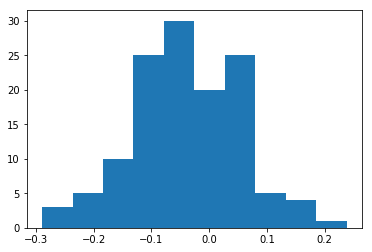

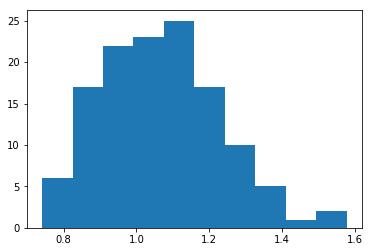

In [62]:
plt.figure()
plt.hist(np.mean(encoded_imgs, axis=1))
plt.figure()
plt.hist(np.std(encoded_imgs, axis=1))
plt.show()

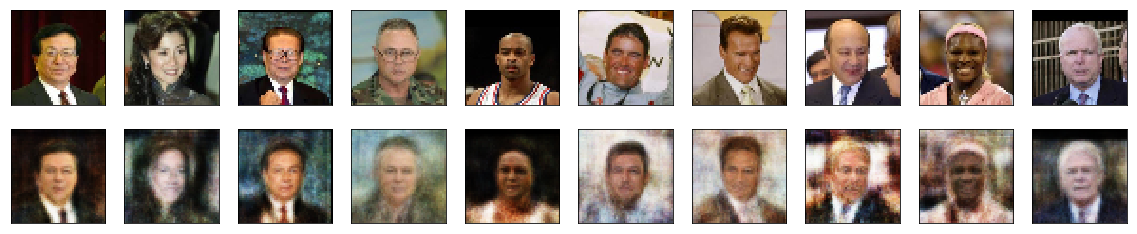

In [63]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(50, 50, 3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(50, 50, 3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

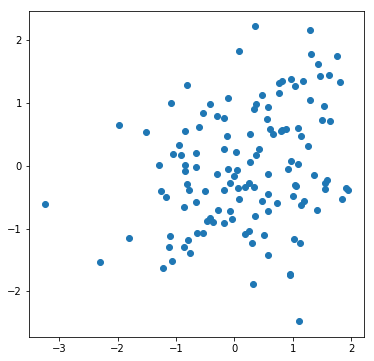

In [64]:
plt.figure(figsize=(6, 6))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], alpha=1)
plt.show()

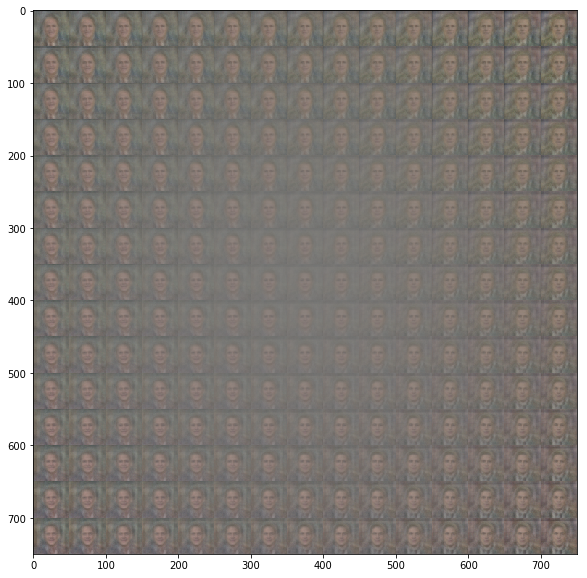

In [65]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 50
figure = np.zeros((digit_size * n, digit_size * n, 3))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[0]*(latent_dim-2)+[xi, yi]]) * epsilon_std
        x_decoded = sess.run(net.core_model.output_z, feed_dict={net.ph.z:z_sample})
        digit = x_decoded[0].reshape(digit_size, digit_size, 3)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)

plt.show()

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sess.run(net.core_model.output_z, feed_dict={net.ph.z:np.random.normal(size=(1, latent_dim), loc=0, scale=1)}).reshape(50, 50, 3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(sess.run(net.core_model.output_z, feed_dict={net.ph.z:np.random.normal(size=(1, latent_dim), loc=0, scale=1)}).reshape(50, 50, 3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()